In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [3]:
import tensorflow as tf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset and Select Ticker

In [5]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
df = stock_df[stock_filt]
window = 30
df = clean_stock_data(df, window)
df.head()

,date,open,high,low,close,adj_close,volume,stock_name,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,258.493347,258.493347,53868000.0,4.709991
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,258.493347,258.406677,52481100.0,5.220001
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,260.510010,258.406677,65470700.0,6.907776
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,260.510010,258.406677,62927475.0,7.106659
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,260.916656,258.406677,59121660.0,6.581329


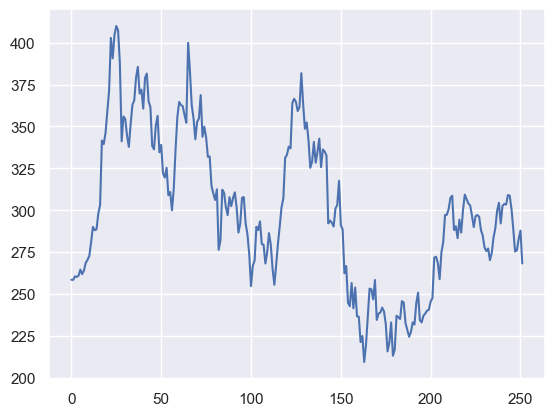

In [6]:
plt.plot(df['close'].values)

### Generate Useful Features

In [8]:
features = gen_features(df)
#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,target,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower
30,-0.415753,1.389737,-0.225144,1.205485,1.225250,1.240823,1.294347,0.337084,0.377391,-0.040307,1.225250,2.329673,0.120826
31,-2.829310,1.274551,-0.123877,0.834094,1.271798,1.244036,1.048356,0.298930,0.361699,-0.062768,1.271798,2.295270,0.248325
32,-1.938224,1.195642,0.185585,1.239311,1.307861,1.239427,1.022191,0.259337,0.341226,-0.081890,1.307861,2.261470,0.354252
33,4.079377,1.361721,-0.103368,1.246601,1.353595,1.251074,1.061015,0.238609,0.320703,-0.082094,1.353595,2.216830,0.490360
34,3.250121,1.494039,0.042524,1.399640,1.405584,1.274213,1.051915,0.230206,0.302603,-0.072398,1.405584,2.159023,0.652145


### Generate GRU train and test split

In [10]:
target = 1 #predict closing
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))
test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (201, 20, 13)
> Data y: (201, 1)
Train Set
> Data X: (171, 20, 13)
> Data y: (171, 1)
Test Set
> Data X: (30, 20, 13)
> Data y: (30, 1)


### Define Model

In [12]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [13]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=1, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4083  


In [14]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=100,
    batch_size=128
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.3381 - val_loss: 0.2157
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2815 - val_loss: 0.2495
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.5898 - val_loss: 0.0995
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1654 - val_loss: 0.1287
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2583 - val_loss: 0.1416
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.3433 - val_loss: 0.0769
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1900 - val_loss: 0.0718
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0818 - val_loss: 0.1768
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1560 - val_loss: 0.2094
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1881 - val_loss: 0.1239
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1026 - val_loss: 0.0582
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0690 - val_loss

### Plot Performance

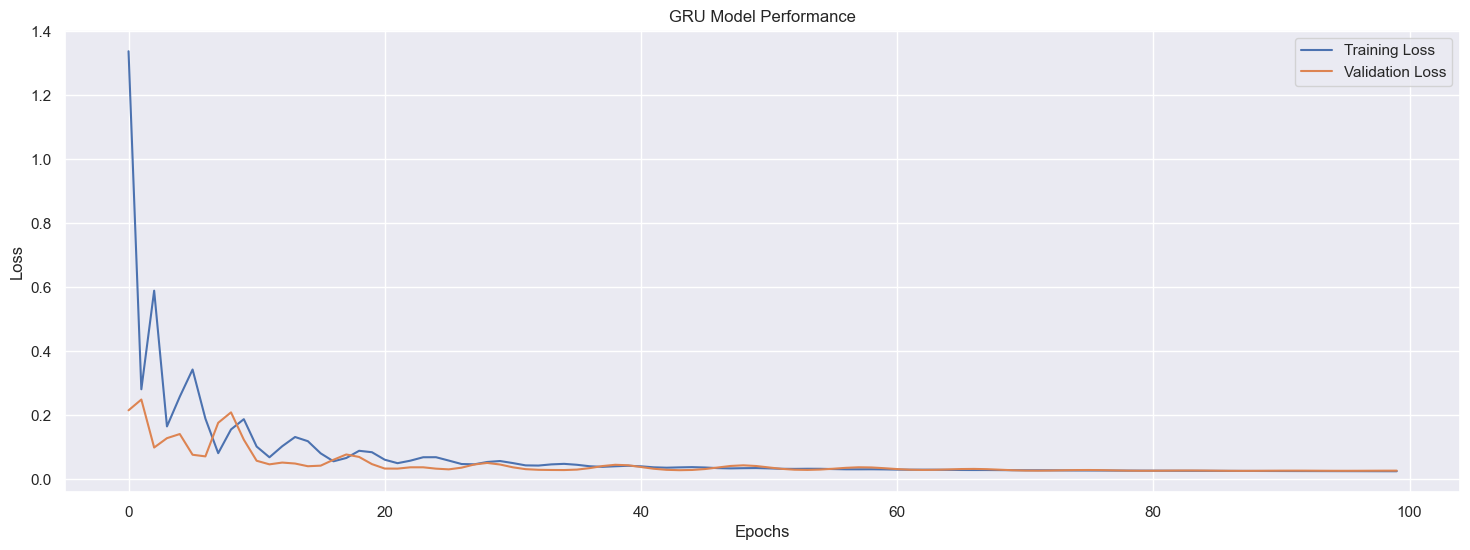

In [15]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


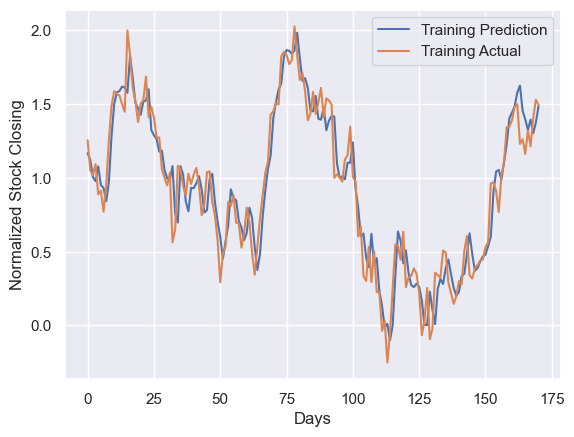

In [16]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions, label='Training Prediction')
plt.plot(train_actual, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing')
plt.legend()

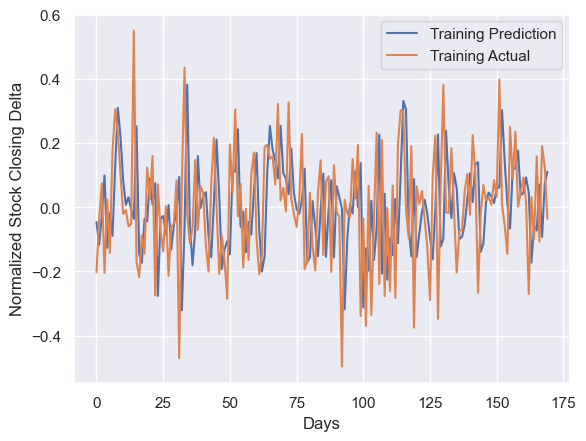

In [17]:
training_diff = np.diff(train_predictions.flatten())
actual_diff = np.diff(train_actual.flatten())
plt.plot(training_diff, label='Training Prediction')
plt.plot(actual_diff, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


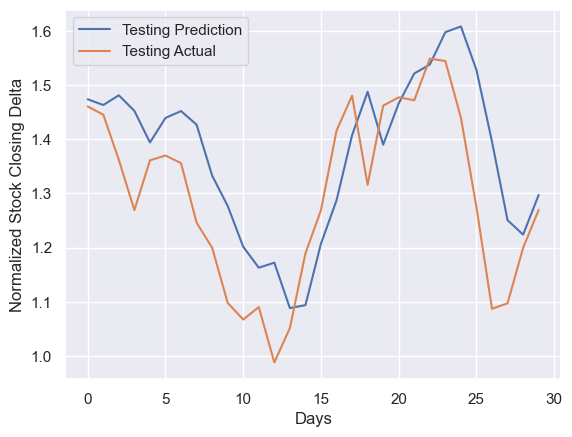

In [18]:
test_predictions = mymodel.predict(datax_test)
test_actual = datay_test
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(test_actual, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()